# Draft 1 - Capstone

## Stock Price Predictor

### Inputs
* stock symbol of NYSE or NASDAQ stock exchange
* daily trading data
* past date range, at least 1 month ago, for training model

#### Trading Data Features
* Opening Price (Open)
* Highest stock trading price (High)
* Number of stock shares traded (Volume)
* Closing price adjusted for splits and dividends (Adjusted Close)

### Processing

#### Parameters
* test date range, after training date range
* prediction date, after test date range

#### Model
* regression model

*TODO: select a model or set of models*

### Output
Predicted Adjusted Close for a specific trading day, the prediction date

### Metric for Evaluation
Predicted stock price within -/+5% of actual Adjusted Close

## Exploration

### Inputs
First, the stock symbol and date range are collected and minimally checked.

The data range will identify the stock data to be used to train the model.

In [9]:
from datetime import datetime

# Stock Symbol - Apple Inc. (AAPL) NASDAQ
stock_symbol = 'aapl'

# Date range for training data; backwards so courtesy swap flagged
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2012-12-31', '%Y-%m-%d')

# Validate date range; exchange values if invalid range
if (start_date > end_date):
    (start_date, end_date) = (end_date, start_date)

# TODO: validate end date one month ago

# Ensure end date is past
today = datetime.now()
if (end_date > today):
    print('{} is not after {}'.format(end_date.date(), today.date()))

print('Let\'s predict {} stock price using the date range from {} to {}.'.format(stock_symbol.upper(),
                                                                                 start_date.date(), end_date.date()))

Let's predict AAPL stock price using the date range from 2012-12-31 to 2017-01-01.


### Process
Select prediction date between today's date and test end date.


#### Dates
* Test Start Date: 2017-02-14
* Test End Date: 2017-04-02


In [28]:
# Test date range for model
test_start_date = datetime.strptime('2017-02-14', '%Y-%m-%d')
test_end_date = datetime.strptime('2017-04-02', '%Y-%m-%d')

# Prediction date
prediction_date = datetime.fromordinal(test_end_date.toordinal() + ((today.toordinal() - test_end_date.toordinal()) / 2))

# adjust if non-weekday (ordinals 0-4 are M-F): Saturday back one day, Sunday forward one day
if (prediction_date.weekday() == 5):
    prediction_date = datetime.fromordinal(prediction_date.toordinal() - 1)
elif (prediction_date.weekday() == 6):
    prediction_date = datetime.fromordinal(prediction_date.toordinal() + 1)

print('Prediction is {}'.format(prediction_date.date()))

Prediction is 2017-05-05


#### Stock Data
Stock data will be downloaded from [Quandl](https:///www.quandl.com).

> "Quandl (/ˈkwɑːndəl/) is a platform for financial, economic, and alternative data that serves investment professionals. Quandl sources data from over 500 publishers. All Quandl's data are accessible via an API. API access is possible through packages for multiple programming languages including R, Python, Matlab, Maple (software) and Stata." [Wikipedia](https://en.wikipedia.org/wiki/Quandl)

In [33]:
import quandl

#token = '' # TODO: omit from committed code

# time series call for pd.DataFrame object
data = quandl.get("WIKI/"+stock_symbol, start_date=start_date, end_date=end_date)

# as numpy array; TODO: use case
# data = quandl.get("WIKI/AAPL", returns="numpy")

In [34]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-12-31,41.05,42.105,40.930,42.01,149400.0,0.0,1.0,37.131298,38.085586,37.022754,37.999655,149400.0
2013-01-02,42.88,44.040,42.620,43.55,367300.0,0.0,1.0,38.786604,39.835868,38.551424,39.392644,367300.0
2013-01-03,43.62,43.920,43.374,43.76,233200.0,0.0,1.0,39.455962,39.727323,39.233446,39.582597,233200.0
2013-01-04,44.05,44.070,43.749,43.90,104400.0,0.0,1.0,39.844913,39.863004,39.572647,39.709233,104400.0
2013-01-07,43.54,43.880,43.340,43.50,113800.0,0.0,1.0,39.383599,39.691142,39.202691,39.347417,113800.0


In [37]:
# Explore if both NASDAQ and NYSE stock symbol data are available (Quandl), via 'Applied Industrial Technologies' check
stock_symbol = 'AIT'
test_data = quandl.get("WIKI/"+stock_symbol, start_date=start_date, end_date=end_date)

In [41]:
test_data.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-12-23,60.45,61.350,60.2,61.20,150911.0,0.0,1.0,59.890459,60.782128,59.642773,60.633516,150911.0
2016-12-27,61.40,61.650,60.8,60.85,168563.0,0.0,1.0,60.831665,61.079351,60.237219,60.286756,168563.0
2016-12-28,61.05,61.300,59.6,60.05,181645.0,0.0,1.0,60.484905,60.732591,59.048326,59.494161,181645.0
2016-12-29,60.20,60.525,59.6,60.00,116698.0,0.0,1.0,59.642773,59.964764,59.048326,59.444624,116698.0
2016-12-30,59.95,59.950,59.1,59.40,154468.0,0.0,1.0,59.395087,59.395087,58.552955,58.850178,154468.0


In [43]:
# Actual stock data for prediction date
actual_data = quandl.get("WIKI/"+stock_symbol, start_date=prediction_date, end_date=prediction_date)
actual_data

pandas.core.frame.DataFrame

In [65]:
# Input features dataframe
# test_data[['Open','High', 'Volume','Adj. Close']]

# Review of P4F ch 6 items
# test_data.index
# test_data.columns
# test_data.ix[['2016-12-23']] -- why NaNs
# test_data.ix[test_data.index[1:3]] -- works ['2013-01-02','2013-01-03']
# test_data[['Open','High', 'Volume','Adj. Close']].std()
# test_data[['Open','High', 'Volume','Adj. Close']].mean()
test_data[['Open','High', 'Volume','Adj. Close']].describe()

,Open,High,Volume,Adj. Close
count,1009.000000,1009.000000,1.009000e+03,1009.000000
mean,45.779891,46.203784,2.030417e+05,43.273835
std,4.572637,4.569646,1.090694e+05,4.419924
min,36.210000,37.350000,3.540000e+04,35.453095
25%,42.580000,42.940000,1.346000e+05,39.998685
50%,45.900000,46.280000,1.785420e+05,43.504970
75%,48.530000,48.930000,2.405020e+05,45.577037
max,62.600000,62.650000,1.155300e+06,61.723335


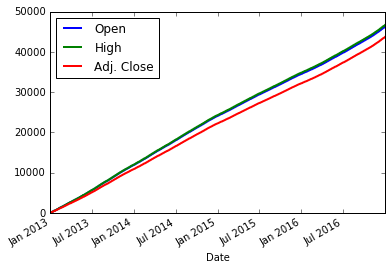

In [67]:
%matplotlib inline
test_data[['Open','High', 'Adj. Close']].cumsum().plot(lw=2.0)

[^1]: https://www.quandl.com